# Project Code 

## import main modules

In [1]:
from __future__ import print_function
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

# Training Neural Network on Datasets
Comment: We can also do it on MNIST dataset

## Setting up

In [2]:
# Initial parameters
dataset = 'mnist'
batch_size = 64
epochs = 10
lr = 0.01

In [4]:
# Data Loading
# This cell might take some time when you run it for the first time
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)
elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Processing...
Done!


In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images[0].shape # image size

torch.Size([1, 28, 28])

## Viewing

In [8]:
# Design the function to show an image
import matplotlib.pyplot as plt

def imshow(img):
    """function to show an image"""
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# classes of images
if dataset == 'mnist':
    classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
elif dataset == 'cifar10':
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

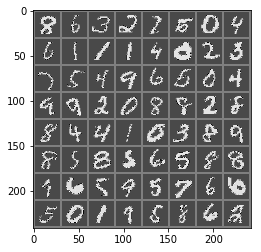

Label is as follows:
     8     6     3     2     2     5     0     4
     6     1     1     1     4     0     2     3
     7     5     4     9     6     5     0     4
     9     9     2     0     8     8     2     8
     8     4     4     1     0     3     8     9
     8     5     8     5     6     5     8     8
     9     6     5     9     5     7     6     6
     5     0     1     9     5     8     6     2



In [9]:
# This cell can give us a better understanding of dataset.
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print('Label is as follows:')
print(' ' + ' '.join('%5s' % classes[labels[j]] if (j + 1) % 8 != 0 else '%5s' % classes[labels[j]] + '\n' for j in range(len(labels)) ))

## Main function and neural network

Single layer

In [16]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784 # number of input
elif dataset == 'cifar10':
    num_inputs = 3072 # number of input

num_outputs = 10 # number of output, the same for both mnist and cifar10 datasets

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        # print(input.shape)
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        output = output
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [17]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [18]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.419335
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.566483
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.679281
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.422897
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.482501
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.327023
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.202066
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.336612
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.560704
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.266839

Test set: Average loss: 0.3374, Accuracy: 9067/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.318007
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.234482
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.319893
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.271231
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.251847
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.219728
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.338632
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.486619
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.362637
T

Two layers

In [19]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hiddens = num_inputs # To prepare for residue network

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        hidden = self.fc1(input)
        output = self.fc2(F.tanh(hidden))
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [20]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [21]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328033
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.793842
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.540469
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.446443
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.518800
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.600092
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.433271
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.326606
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.368656
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.434162

Test set: Average loss: 0.3264, Accuracy: 9089/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.491239
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.542397
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.320088
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.349879
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.358171
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.438849
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.400296
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.306760
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.584201
T

Residue neural network
Comment: not sure if this is the one we talking about

In [22]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs
num_hiddens = num_inputs # To prepare for residue network

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hiddens)
        self.fc2 = nn.Linear(num_hiddens, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        hidden = self.fc1(input) + input # Residue part
        output = self.fc2(F.tanh(hidden))
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [23]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test():
    network.eval() 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [24]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305161
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.670281
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.535892
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.477066
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.333151
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.298865
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.462426
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.326125
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.258908
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.363147

Test set: Average loss: 0.3130, Accuracy: 9145/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.216654
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.602279
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.304850
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.235410
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.217654
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.285679
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.172175
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.278216
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.244202
T